In [1]:
%pip install numpy pandas tqdm scikit-learn tensorflow matplotlib seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def load_dataset():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
    X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return X_train, y_train, X_test, y_test
 
X_train, y_train, X_test, y_test = load_dataset()

In [3]:
X_train.shape

(60000, 28, 28, 1)

In [37]:

import sys
import os

possible_paths = [
    os.path.join('..', 'MLP', 'source'),  
    os.path.join('..', 'CNN', 'source'),  
    os.path.join('MLP', 'source'),
    os.path.join('CNN', 'source'),
    os.path.join(os.path.dirname(os.getcwd()), 'MLP', 'source'),
    os.path.join(os.path.dirname(os.getcwd()), 'CNN', 'source')
]   
for mlp_path in possible_paths:
    abs_path = os.path.abspath(mlp_path)
    if os.path.exists(abs_path) and abs_path not in sys.path:
        sys.path.insert(0, abs_path)
        break

from mlp import MLP
from cnn import Conv2D
from maxpooling import MaxPooling2D
from flatten import FlattenND

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred))


class ConvNN:
    def __init__(self, learning_rate=0.01):
        self.conv1 = Conv2D(relu, relu_prime, 1, 5, learning_rate=learning_rate, k=5)
        self.pool1 = MaxPooling2D(size=2)
        self.conv2 = Conv2D(relu, relu_prime, 5, 10, learning_rate=learning_rate, k=5)
        self.pool2 = MaxPooling2D(size=2)
        
        self.flatten = FlattenND()
        
        flattened_size = 4 * 4 * 10 
        
        self.mlp = MLP(
            x_size=flattened_size,
            y_size=10,
            h_sizes=[128, 64],
            activation_fn=relu,
            activation_fn_prime=relu_prime,
            learning_rate=learning_rate
        )
    
    def forward_pass(self, X):
        out = self.conv1.forward_step(X)
        out = self.pool1.forward_pass(out)
        out = self.conv2.forward_step(out)
        out = self.pool2.forward_pass(out)
        
        flattened = self.flatten.forward_pass(out)
        
        self.mlp.x = flattened
        self.mlp.forward_step()
        
        logits = self.mlp.y
        self.logits = logits
        self.y_softmax = softmax(logits)
        
        return self.y_softmax
    
    def backward_pass(self, y_actual):
        grad_softmax = self.y_softmax - y_actual
        
        grad_mlp = self.mlp.backward_step(None, external_grad=grad_softmax)
        
        grad_flatten = self.flatten.backward_pass(grad_mlp)
        grad_pool2 = self.pool2.backward_pass(grad_flatten)
        grad_conv2 = self.conv2.backward_step(grad_pool2)
        grad_pool1 = self.pool1.backward_pass(grad_conv2)
        grad_conv1 = self.conv1.backward_step(grad_pool1)
        
        return grad_conv1
    
    def predict(self, X):
        return self.forward_pass(X)


In [38]:
from tqdm import tqdm
import random

train_loss_history = [] 

def train_convnn(model: ConvNN, X_train, y_train, epochs=1, batch_size=1):
    global train_loss_history
    n_samples = len(X_train)
    train_loss_history = [] 
    count = 0
    total_loss = 0.0

    for epoch in range(epochs):
        indices = list(range(n_samples))
        random.shuffle(indices)
        
        for idx in tqdm(indices, desc="Training"):
            count += 1

            X_sample = X_train[idx] 
            y_sample = y_train[idx]
            
            y_pred = model.forward_pass(X_sample)
            
            loss = cross_entropy_loss(y_pred, y_sample)
            total_loss += loss

            avg_loss = total_loss / count
            if count % 100 == 0:
                train_loss_history.append(avg_loss) 
            
            model.backward_pass(y_sample)
        
        print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss:.6f}")

def evaluate_convnn(model: ConvNN, X_test, y_test):
    correct = 0
    total = len(X_test)
    
    for i in tqdm(range(total), desc="Evaluating"):
        X_sample = X_test[i]
        y_sample = y_test[i]
        
        y_pred = model.predict(X_sample)
        
        pred_class = np.argmax(y_pred)
        true_class = np.argmax(y_sample)
        
        if pred_class == true_class:
            correct += 1
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")
    return accuracy


In [40]:
model = ConvNN(learning_rate=0.01)

train_convnn(model, X_train, y_train, epochs=1)

Training: 100%|██████████| 60000/60000 [37:45<00:00, 26.48it/s]

Epoch 1/1 - Average Loss: 0.172714


In [41]:
evaluate_convnn(model, X_test, y_test)

Evaluating:   0%|          | 0/10000 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 10000/10000 [02:55<00:00, 57.07it/s]

Accuracy: 98.12% (9812/10000)


0.9812

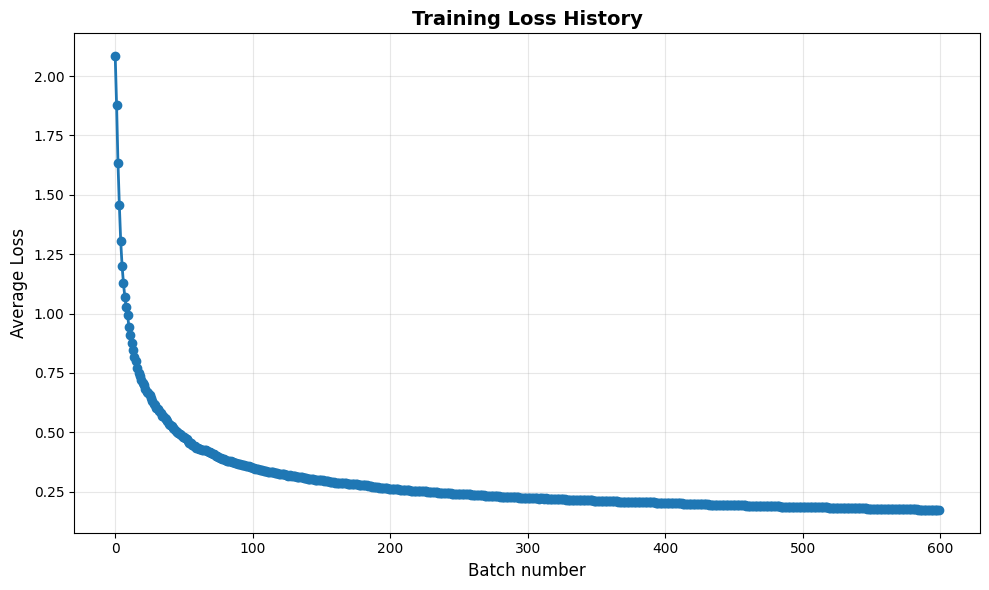

Final training loss: 0.172714


In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, marker='o', linewidth=2, markersize=6)
plt.title('Training Loss History', fontsize=14, fontweight='bold')
plt.xlabel('Batch number', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Final training loss: {train_loss_history[-1]:.6f}")

Computing predictions...


Getting predictions: 100%|██████████| 1000/1000 [00:17<00:00, 56.65it/s]


Confusion Matrix:
[[ 82   0   0   0   1   0   2   0   0   0]
 [  0 125   0   1   0   0   0   0   0   0]
 [  0   0 114   0   0   0   0   2   0   0]
 [  0   0   0 106   0   1   0   0   0   0]
 [  0   1   0   0 106   0   0   1   1   1]
 [  0   0   0   2   0  85   0   0   0   0]
 [  2   0   0   0   0   0  85   0   0   0]
 [  0   0   1   1   0   1   0  96   0   0]
 [  0   0   2   3   0   0   0   1  82   1]
 [  0   0   0   0   0   1   0   0   1  92]]


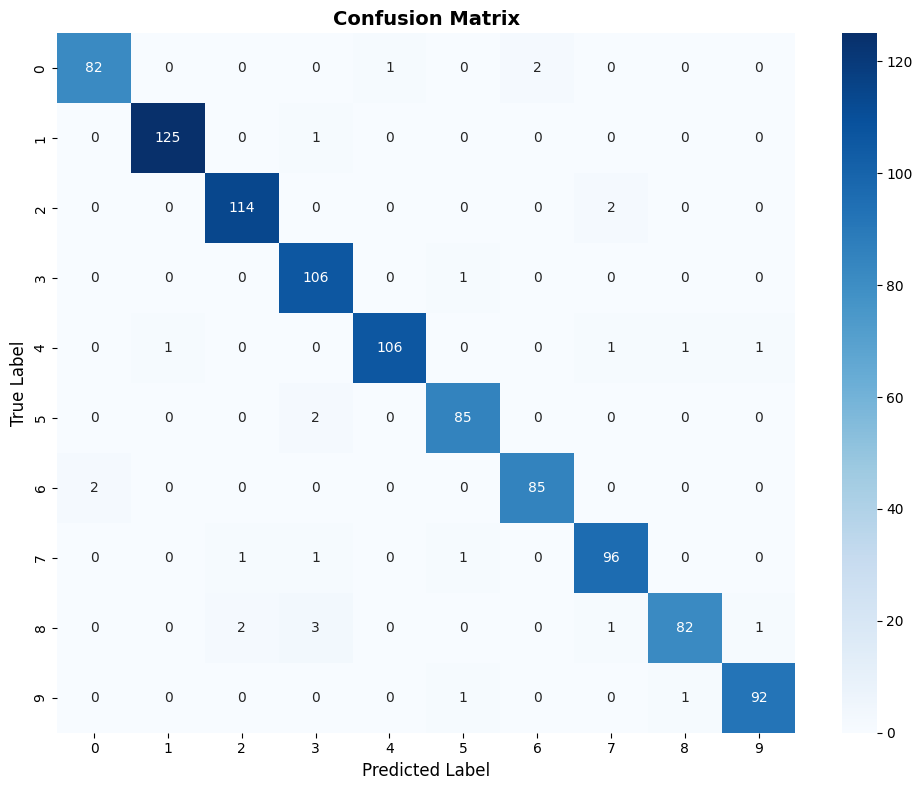


Metrics:
Accuracy:  0.9730 (97.30%)
Precision: 0.9733
Recall:    0.9730
F1-score:  0.9730


In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

def get_predictions_and_probs(model, X_test, y_test):
    """Получает предсказания классов и вероятности для всех классов"""
    y_pred_classes = []
    y_pred_probs = []
    y_true_classes = []
    
    print("Computing predictions...")
    for i in tqdm(range(len(X_test)), desc="Getting predictions"):
        X_sample = X_test[i]
        y_sample = y_test[i]
        
        y_pred = model.predict(X_sample)
        
        y_pred_classes.append(np.argmax(y_pred))
        y_pred_probs.append(y_pred)
        y_true_classes.append(np.argmax(y_sample))
    
    return np.array(y_true_classes), np.array(y_pred_classes), np.array(y_pred_probs)

y_true, y_pred_classes, y_pred_probs = get_predictions_and_probs(model, X_test[:1000], y_test[:1000])

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

print(f"\nMetrics:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


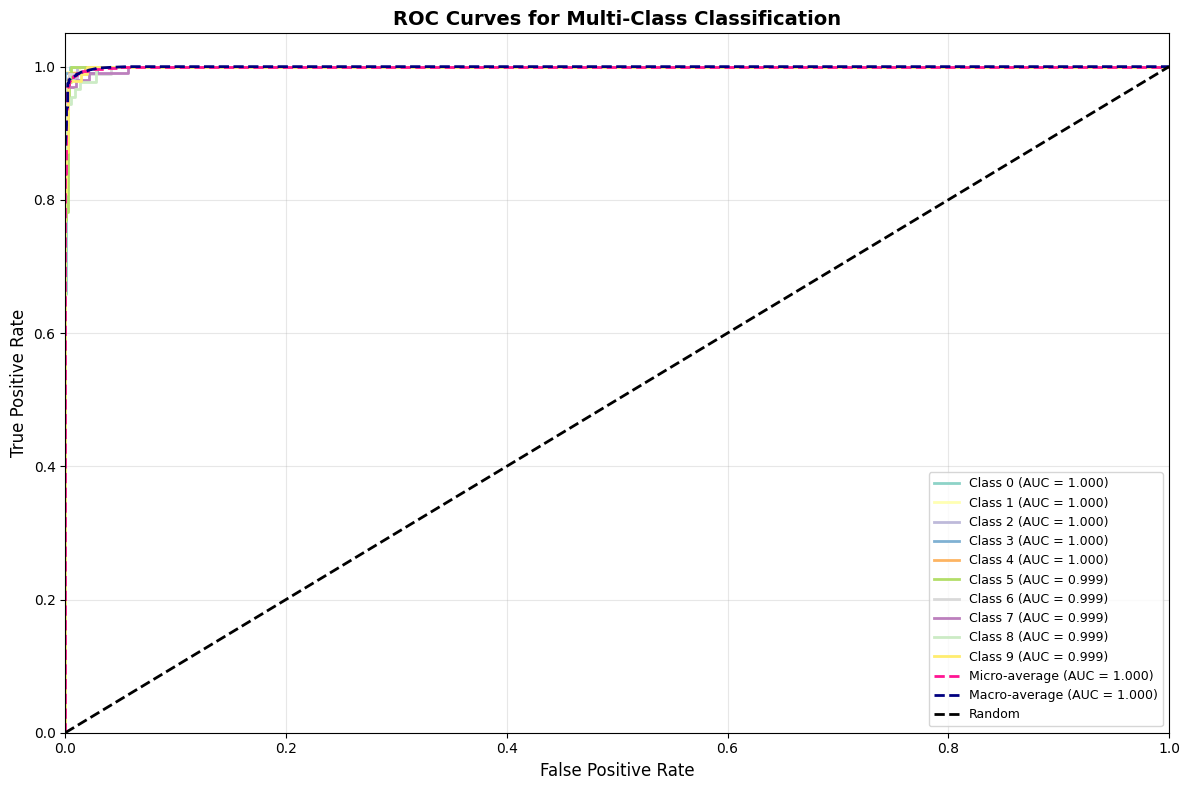


AUC Scores:
Micro-average AUC: 0.9995
Macro-average AUC: 0.9995

Per-class AUC:
  Class 0: 0.9995
  Class 1: 0.9999
  Class 2: 0.9997
  Class 3: 0.9997
  Class 4: 0.9997
  Class 5: 0.9994
  Class 6: 0.9995
  Class 7: 0.9990
  Class 8: 0.9989
  Class 9: 0.9993


In [44]:
y_test_bin = label_binarize(y_true, classes=list(range(10)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(10)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(10):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 10
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, 10))
for i, color in zip(range(10), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

plt.plot(fpr["micro"], tpr["micro"], 
         label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=2)


plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.3f})',
         color='navy', linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Multi-Class Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Scores:")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
print(f"\nPer-class AUC:")
for i in range(10):
    print(f"  Class {i}: {roc_auc[i]:.4f}")


In [26]:
from sklearn.manifold import TSNE

print("Computing t-SNE embeddings...")
print("This may take a while...")

n_samples_for_tsne = min(1000, len(X_test))
X_tsne = []
y_true_tsne = []
y_pred_tsne = []
errors_mask = []

print("Collecting predictions...")
for i in tqdm(range(n_samples_for_tsne), desc="Collecting data"):
    X_sample = X_test[i]
    y_sample = y_test[i]
    
    y_pred = model.predict(X_sample)
    
    pred_class = np.argmax(y_pred)
    true_class = np.argmax(y_sample)
    
    out = model.conv1.forward_step(X_sample)
    out = model.pool1.forward_pass(out)
    out = model.conv2.forward_step(out)
    out = model.pool2.forward_pass(out)
    flattened_features = model.flatten.forward_pass(out)
    
    X_tsne.append(flattened_features)
    y_true_tsne.append(true_class)
    y_pred_tsne.append(pred_class)
    errors_mask.append(pred_class != true_class)

X_tsne = np.array(X_tsne)
y_true_tsne = np.array(y_true_tsne)
y_pred_tsne = np.array(y_pred_tsne)
errors_mask = np.array(errors_mask)

print(f"Computing t-SNE (this may take a few minutes)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_2d = tsne.fit_transform(X_tsne)

print("t-SNE completed!")


Computing t-SNE embeddings...
This may take a while...


Computing t-SNE (this may take a few minutes)...
t-SNE completed!


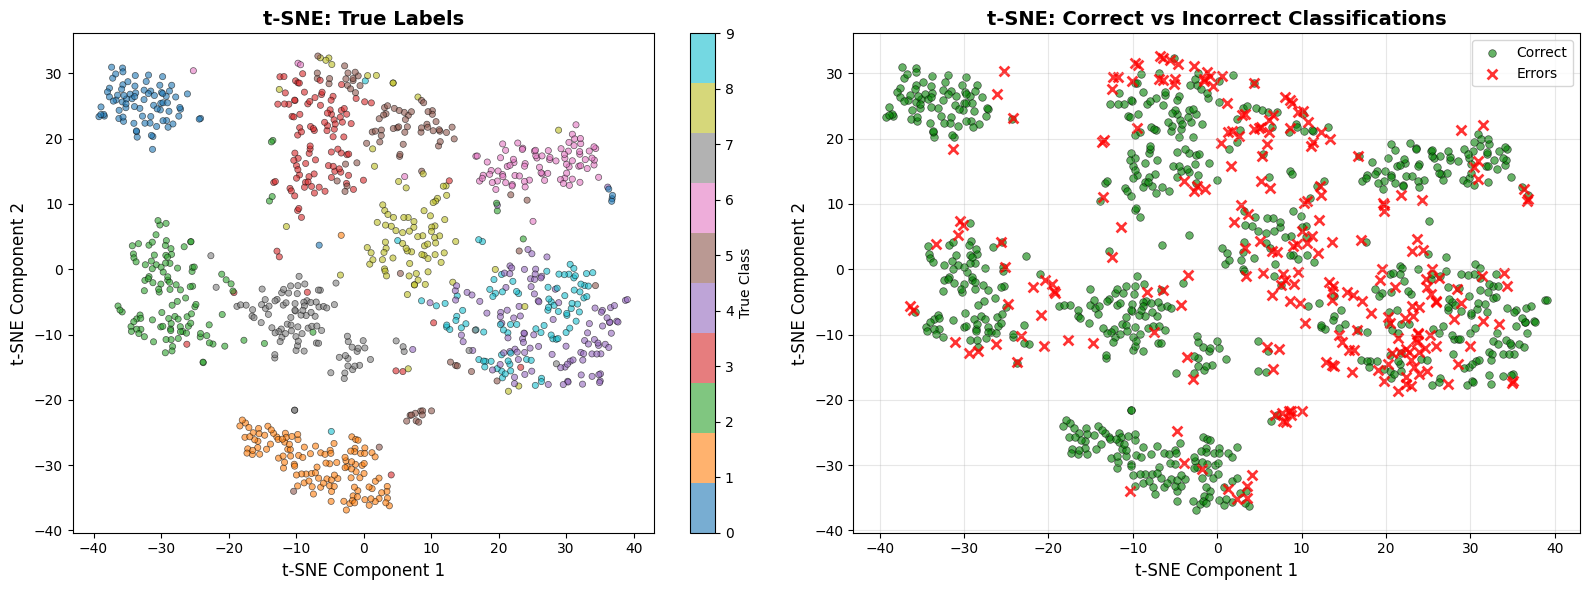


Error Analysis:
Total samples: 1000
Errors: 234 (23.40%)
Correct: 766 (76.60%)

Confusion Matrix for Errors Only:
[[ 0  0  0  0  1  0  5  0  0  0]
 [ 0  0  0  3  0  0  0  2  0  1]
 [ 4  0  0  3  4  0  5 12  0  0]
 [ 1  1  1  0  0  1  1  8  0  1]
 [ 0  0  0  0  0  0  2  0  0 53]
 [ 1  0  0 30  4  0  4  4  2 11]
 [ 2  0  0  0  3  3  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  6]
 [ 1  0  1 11  4  2  7  7  0 11]
 [ 0  0  0  2  2  0  0  4  0  0]]

Most Common Misclassifications:
  True: 0 -> Predicted: 4: 1 times
  True: 0 -> Predicted: 6: 5 times
  True: 1 -> Predicted: 3: 3 times
  True: 1 -> Predicted: 7: 2 times
  True: 1 -> Predicted: 9: 1 times
  True: 2 -> Predicted: 0: 4 times
  True: 2 -> Predicted: 3: 3 times
  True: 2 -> Predicted: 4: 4 times
  True: 2 -> Predicted: 6: 5 times
  True: 2 -> Predicted: 7: 12 times
  True: 3 -> Predicted: 0: 1 times
  True: 3 -> Predicted: 1: 1 times
  True: 3 -> Predicted: 2: 1 times
  True: 3 -> Predicted: 5: 1 times
  True: 3 -> Predicted: 6: 1 t

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                           c=y_true_tsne, cmap='tab10', 
                           s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_title('t-SNE: True Labels', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
plt.colorbar(scatter1, ax=axes[0], label='True Class')

colors_map = ['green' if not err else 'red' for err in errors_mask]
axes[1].scatter(X_tsne_2d[~errors_mask, 0], X_tsne_2d[~errors_mask, 1], 
                c='green', s=30, alpha=0.6, label='Correct', edgecolors='black', linewidth=0.5)
axes[1].scatter(X_tsne_2d[errors_mask, 0], X_tsne_2d[errors_mask, 1], 
                c='red', s=50, alpha=0.8, label='Errors', marker='x', linewidth=2)
axes[1].set_title('t-SNE: Correct vs Incorrect Classifications', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_errors = np.sum(errors_mask)
n_total = len(errors_mask)
print(f"\nError Analysis:")
print(f"Total samples: {n_total}")
print(f"Errors: {n_errors} ({n_errors/n_total*100:.2f}%)")
print(f"Correct: {n_total - n_errors} ({(n_total-n_errors)/n_total*100:.2f}%)")

error_confusion = confusion_matrix(y_true_tsne[errors_mask], y_pred_tsne[errors_mask])
print(f"\nConfusion Matrix for Errors Only:")
print(error_confusion)

print("\nMost Common Misclassifications:")
for true_class in range(10):
    for pred_class in range(10):
        if true_class != pred_class and error_confusion[true_class, pred_class] > 0:
            print(f"  True: {true_class} -> Predicted: {pred_class}: {error_confusion[true_class, pred_class]} times")
